In [24]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt

In [25]:
events_dict = {
    'BLUE: first_blood': 0,
    'BLUE: dragon': 1,
    'BLUE: herald': 2,
    'BLUE: first_tower_top': 3,
    'BLUE: first_tower_mid': 4,
    'BLUE: first_tower_bot': 5,
    'BLUE: second_tower_top': 6,
    'BLUE: second_tower_mid': 7,
    'BLUE: second_tower_bot': 8,
    'BLUE: third_tower_top': 9,
    'BLUE: third_tower_mid': 10,
    'BLUE: third_tower_bot': 11,
    'BLUE: inhibitor_top': 12,
    'BLUE: inhibitor_mid': 13,
    'BLUE: inhibitor_bot': 14,
    'BLUE: baron': 15,
    'BLUE: elder_dragon': 16,
    'BLUE: nexus_tower': 17,
    'BLUE: nexus': 18,
    'RED: first_blood': 19,
    'RED: dragon': 20,
    'RED: herald': 21,
    'RED: first_tower_top': 22,
    'RED: first_tower_mid': 23,
    'RED: first_tower_bot': 24,
    'RED: second_tower_top': 25,
    'RED: second_tower_mid': 26,
    'RED: second_tower_bot': 27,
    'RED: third_tower_top': 28,
    'RED: third_tower_mid': 29,
    'RED: third_tower_bot': 30,
    'RED: inhibitor_top': 31,
    'RED: inhibitor_mid': 32,
    'RED: inhibitor_bot': 33,
    'RED: baron': 34,
    'RED: elder_dragon': 35,
    'RED: nexus_tower': 36,
    'RED: nexus': 37
}

df = pd.read_csv('data/clean-one-line.csv')
df = df.drop('game', axis=1)
data = df.values.tolist()

for game in data:
    for i, s in enumerate(game):
        if s in events_dict:
            game[i] = events_dict.get(s)

labelsArray = []

for game in data:
    labelsArray += game

sequence = [b for b in labelsArray if not(isinstance(b, float))]

In [26]:
# one hot encode sequence
def one_hot_encode(sequence, n_unique=38):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return np.array(encoding)
 
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [np.argmax(vector) for vector in encoded_seq]

In [27]:
df = pd.DataFrame(one_hot_encode(sequence))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


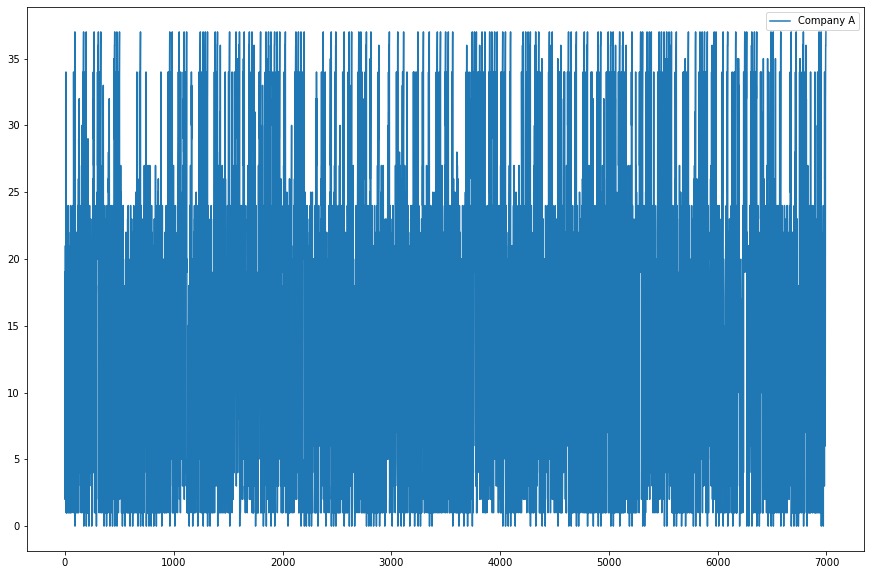

In [28]:
plt.figure(figsize = (15,10))
plt.plot(one_hot_decode(df.values), label='Company A')
plt.legend(loc='best')
plt.show()

In [29]:
array = df.values
array[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [30]:
#split in Train and Test

look_back = 7
forward_days = 1
num_periods = 50

division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [31]:
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [32]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [33]:
len(X_train)

5551

In [35]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 10

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,38), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,38)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["MeanSquaredError", "RootMeanSquaredError", "Accuracy"])

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=1, verbose=2)

Epoch 1/10
2776/2776 - 33s - loss: 0.0256 - mean_squared_error: 0.0256 - root_mean_squared_error: 0.1601 - Accuracy: 0.9737 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_root_mean_squared_error: 0.1601 - val_Accuracy: 0.9737 - 33s/epoch - 12ms/step
Epoch 2/10
2776/2776 - 27s - loss: 0.0256 - mean_squared_error: 0.0256 - root_mean_squared_error: 0.1601 - Accuracy: 0.9737 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_root_mean_squared_error: 0.1601 - val_Accuracy: 0.9737 - 27s/epoch - 10ms/step
Epoch 3/10
2776/2776 - 26s - loss: 0.0256 - mean_squared_error: 0.0256 - root_mean_squared_error: 0.1601 - Accuracy: 0.9737 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_root_mean_squared_error: 0.1601 - val_Accuracy: 0.9737 - 26s/epoch - 9ms/step
Epoch 4/10
2776/2776 - 30s - loss: 0.0256 - mean_squared_error: 0.0256 - root_mean_squared_error: 0.1601 - Accuracy: 0.9737 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_root_mean_squared_error: 0.1601 - va

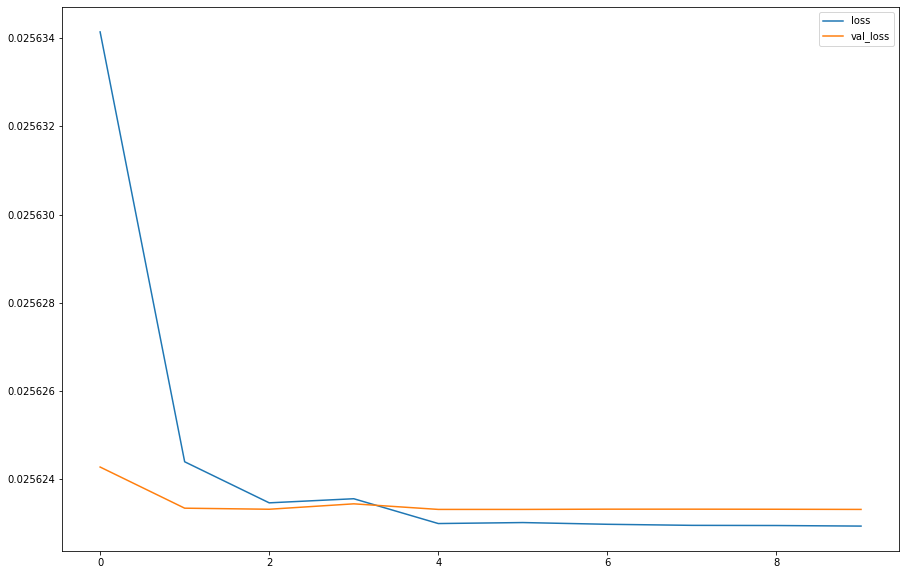

In [36]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [37]:
Xt = model.predict(X_test)

2/2 [==============================] - 2s 6ms/step


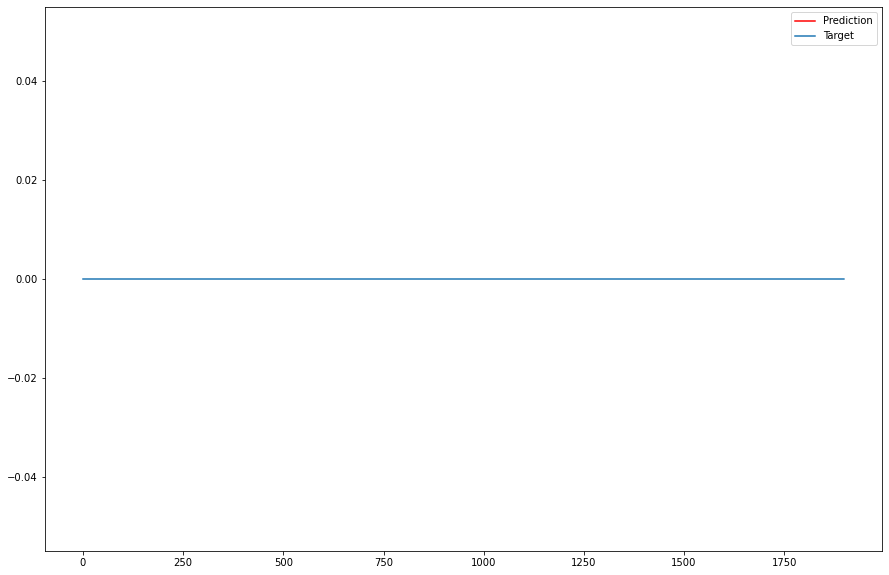

In [40]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], one_hot_decode(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, one_hot_decode(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(one_hot_decode(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

In [41]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [42]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [43]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

2/2 [==============================] - 0s 5ms/step


In [44]:
y = np.concatenate((ytrain, ytest), axis=0)

ValueError: x and y must have same first dimension, but have shapes (6988,) and (265544,)

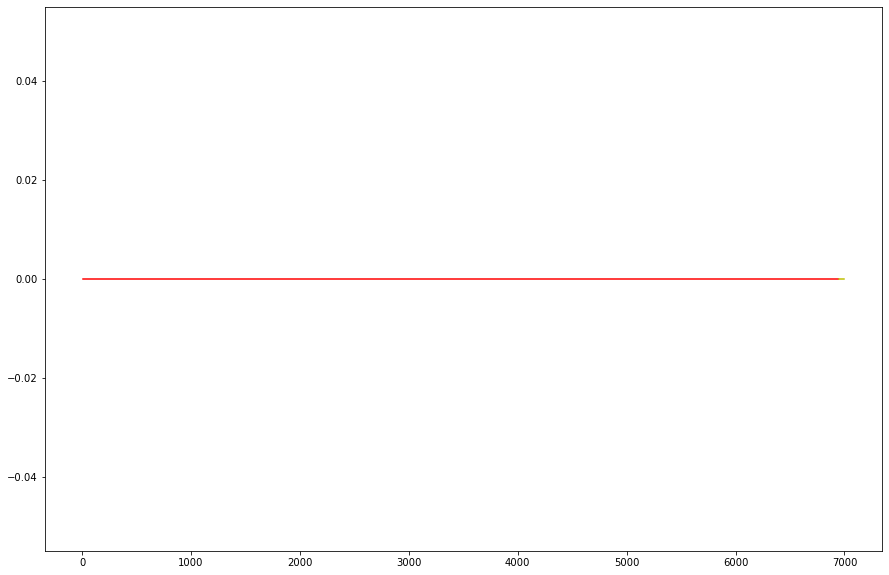

In [45]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], one_hot_decode(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], one_hot_decode(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], one_hot_decode(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 50)             17800     
                                                                 
 lstm_5 (LSTM)               (None, 30)                9720      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 27,551
Trainable params: 27,551
Non-trainable params: 0
_________________________________________________________________
